# Data Preparation

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Dataset is imported
dataset = pd.read_csv('AAL.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y') #To allow easy manipulation and retrieval, the 'Date' column is converted to this format
dataset.set_index('Date', inplace=True) #This converts the whole column to a refrence index for easy manipulation and retrieval of data

features = ['Low', 'Open', 'High', 'Volume', 'Close', 'Adjusted Close']#These are the varibales in the dataset and we want to use them for training the models
scaler = MinMaxScaler() #This function from sklearn library implements min-max scaling to the dataset
dataset_scaled = scaler.fit_transform(dataset[features])#Min-max scaling is applied to the dataset

past_days = 30 #We are making the predictions based on past 30 days data
target_index = features.index('Close') #This is our target variable, we are predicting the closing price of the stock of the next 2 days
x, y = [], []
for i in range(past_days, len(dataset_scaled)): #Since RNNs use sequenced data, we are basically constructing sequences of our data so that RNNs can be easily constructed
    x.append(dataset_scaled[i - past_days:i, :]) #This creates a windown of 30 days
    y.append(dataset_scaled[i, target_index])

x = np.array(x)
y = np.array(y)


In [2]:
dataset.shape

(4333, 6)

In [3]:
dataset.tail()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
2022-12-06,14.00,14.14,20781500,14.34,14.33,14.33
2022-12-07,13.53,14.24,28161400,14.24,13.55,13.55
2022-12-08,13.38,13.65,25300900,13.80,13.60,13.60
2022-12-09,13.42,13.52,18489800,13.66,13.53,13.53
2022-12-12,13.45,13.49,7161518,13.91,13.90,13.90


In [4]:
#We want our dataset to be divided in such a way that 70% of it is training data, 15% of it test data and 15% of it is validation set which helps us do hyper parameter tuning
training_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

#Based on our requirements, we are finding out indices along which our dataset can be subdivided
training_size = int(training_ratio * len(x))
val_size = int(val_ratio * len(x))
test_size = len(x) - training_size - val_size

#Dataset splitting is now done based on the indices we calculated above
x_training, y_training = x[:training_size], y[:training_size]
x_val, y_val = x[training_size:training_size + val_size], y[training_size:training_size + val_size]
x_test, y_test = x[training_size + val_size:], y[training_size + val_size:]

#This section of code basically converts our dataset into tensors so that RNNs can be implemented on them effectively.
x_training, y_training = torch.tensor(x_training, dtype=torch.float32), torch.tensor(y_training, dtype=torch.float32)
x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

#Dataloaders are created so that the data can be fed to the models in the batches of size 32
batch_size = 32
training_load = DataLoader(TensorDataset(x_training, y_training), batch_size=batch_size, shuffle=True) #Here shuffle = True basically means that the batches in training set will be randomly shuffled
val_load = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_load = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


In [5]:
#Defining the vanilla rnn model
class vanilla(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0): #This basically sets up default configuration of the model
        super(vanilla, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) #This sets up the rnn layer
        self.fc = nn.Linear(hidden_size, output_size) #The fully connected layer pools the information from the hidden state and creates the output

    def forward(self, x):#This section of code defines the forward pass
        out, _ = self.rnn(x) #The hidden states are calculated here
        out = self.fc(out[:, -1, :]) #The output is then passed onto the fully connected layer
        return out

#Defining the lstm model
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):  #This basically sets up default configuration of the model
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) #This sets up the lstm layer
        self.fc = nn.Linear(hidden_size, output_size) #The fully connected layer pools the information from the hidden state and creates the output

    def forward(self, x): #This section of code defines the forward pass
        out, _ = self.lstm(x) #The hidden states are calculated here
        out = self.fc(out[:, -1, :]) #The output is then passed onto the fully connected layer
        return out

#Defining the lstm model
class gru(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0): #This basically sets up default configuration of the model
        super(gru, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) #This sets up the gru layer
        self.fc = nn.Linear(hidden_size, output_size) #The fully connected layer pools the information from the hidden state and creates the output

    def forward(self, x): #This section of code defines the forward pass
        out, _ = self.gru(x) #The hidden states are calculated here
        out = self.fc(out[:, -1, :]) #The output is then passed onto the fully connected layer
        return out


# Minimising MSE Loss

Epoch 1/20, training Loss: 0.0118, Val Loss: 0.0008
Epoch 2/20, training Loss: 0.0004, Val Loss: 0.0006
Epoch 3/20, training Loss: 0.0004, Val Loss: 0.0006
Epoch 4/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0007
Epoch 11/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 12/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 13/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 14/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 15/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0005
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0003
Ep

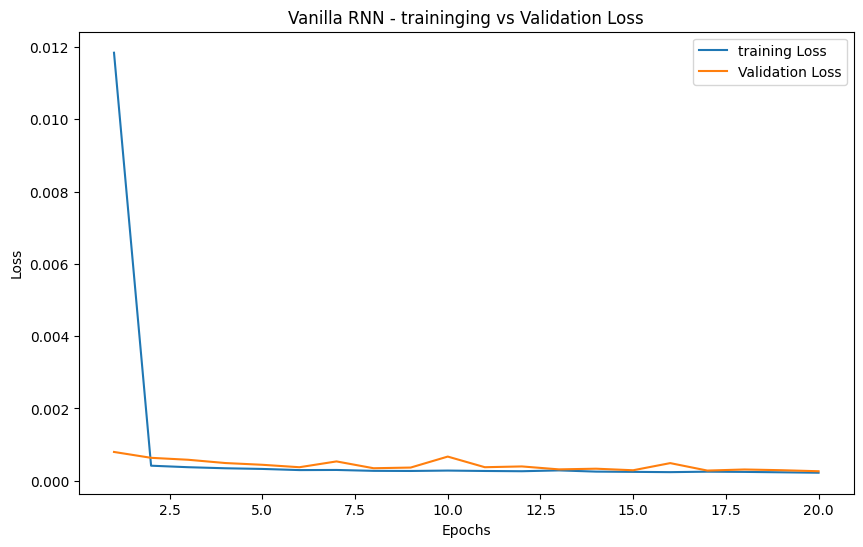


Vanilla RNN Metrics:
MSE: 0.5206, MAE: 0.5205, RMSE: 0.7215, R2: 0.9605


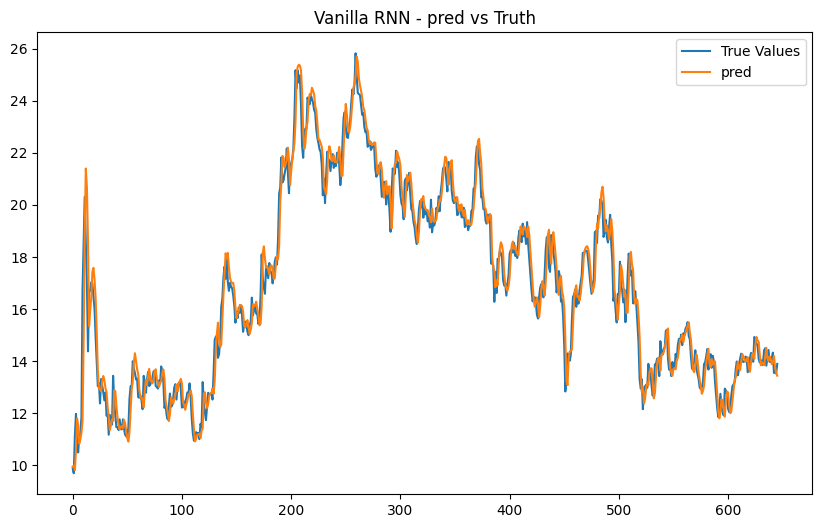

In [6]:
vanilla_rnn = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1) #This creates an instance of the vanilla rnn class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #This line of code allows the model to train on a gpu
vanilla_rnn.to(device)

criteria = nn.MSELoss() #Here, we specified that we want want to minimise the mean squared errors
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.001) #Here, we specified that we want to use adam optimizer
epochs = 20

training_losses, val_losses = [], [] #These store all the losses in all the epochs
for epoch in range(epochs):
    vanilla_rnn.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad() #This line of code sets the gradient back to zero
        outputs = vanilla_rnn(x_batch) #Ths calculates predictions based on the input
        loss = criteria(outputs.squeeze(), y_batch) #This calculated the loss term between truth values and predictions
        loss.backward() #This line of code starts the backpropogation step
        optim.step() #The model parameters are updated here based on the gradients
        training_loss += loss.item() #Training losses are added to this list
    training_loss /= len(training_load)
    training_losses.append(training_loss)


    vanilla_rnn.eval() #This line of code disables the dropout
    val_loss = 0
    with torch.no_grad(): #Gradient calculation is stopped here
        for x_batch, y_batch in val_load: #Each batch of data loops to calculate predictions
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss) #Validation losses are stored in this list
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

#Here, we have plotted the training v/s validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Vanilla RNN - traininging vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Now, the model is implemented on the testing dataset
vanilla_rnn.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

#Because we used min-max scaling, these lines of code undoes the transformation
pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

#Here, we have calculated the various performance metrics
mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nVanilla RNN Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Vanilla RNN - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [13.69168589  6.81191501]


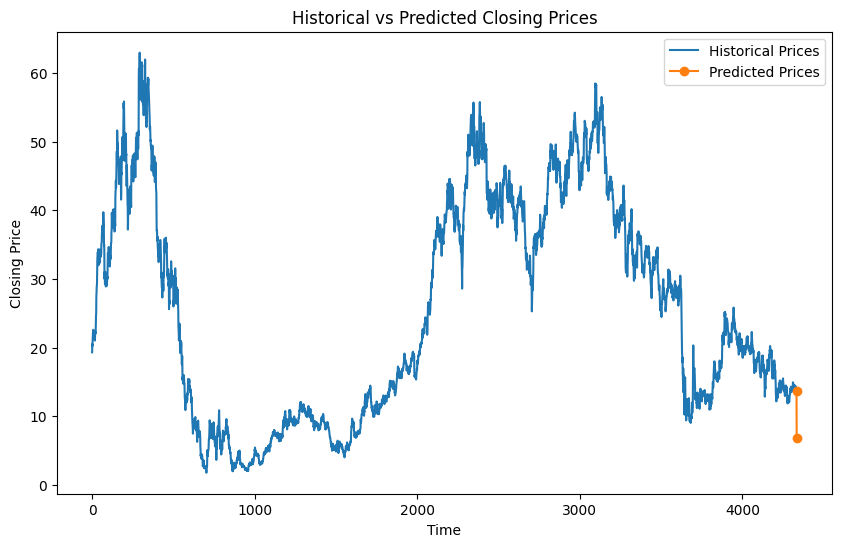

In [7]:
#In this section of code, we make the predictions of the closing price of next two days based on past 30 days
last_sequence = dataset_scaled[-past_days:, :]  #Here, we have created a sequence of data for the past 30 days which will be fed to the model

predictions = []

vanilla_rnn.eval()
with torch.no_grad():
    for _ in range(2):  #We are using a for loop to get the predictions of next 2 days
        #Here, we have converted this sequence to tensor
        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        #Using this line of code, we make the prediction
        next_pred_scaled = vanilla_rnn(input_sequence).squeeze().cpu().numpy()

        #We use this line of code to store the predictions
        predictions.append(next_pred_scaled)

        #This section of code updates the input sequence
        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

#This line of code undoes the min-max scaling
predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]
print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

#Here, we have plotted the truth values and the forecst of the next 2 days
plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0181, Val Loss: 0.0007
Epoch 2/20, training Loss: 0.0006, Val Loss: 0.0008
Epoch 3/20, training Loss: 0.0005, Val Loss: 0.0006
Epoch 4/20, training Loss: 0.0005, Val Loss: 0.0006
Epoch 5/20, training Loss: 0.0005, Val Loss: 0.0005
Epoch 6/20, training Loss: 0.0005, Val Loss: 0.0007
Epoch 7/20, training Loss: 0.0004, Val Loss: 0.0006
Epoch 8/20, training Loss: 0.0004, Val Loss: 0.0006
Epoch 9/20, training Loss: 0.0004, Val Loss: 0.0005
Epoch 10/20, training Loss: 0.0004, Val Loss: 0.0005
Epoch 11/20, training Loss: 0.0004, Val Loss: 0.0004
Epoch 12/20, training Loss: 0.0004, Val Loss: 0.0005
Epoch 13/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 14/20, training Loss: 0.0003, Val Loss: 0.0008
Epoch 15/20, training Loss: 0.0003, Val Loss: 0.0006
Epoch 16/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 17/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 18/20, training Loss: 0.0003, Val Loss: 0.0007
Epoch 19/20, training Loss: 0.0003, Val Loss: 0.0003
Ep

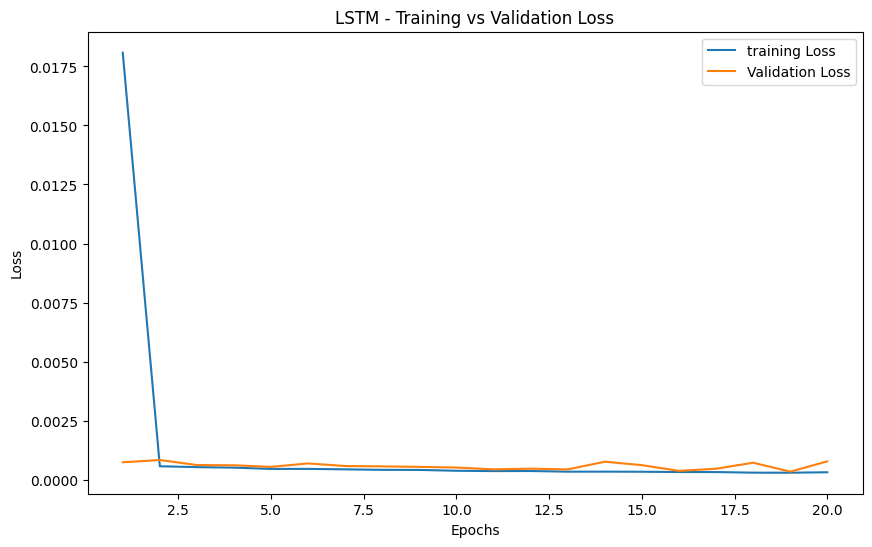


LSTM Metrics:
MSE: 1.4906, MAE: 1.0317, RMSE: 1.2209, R2: 0.8868


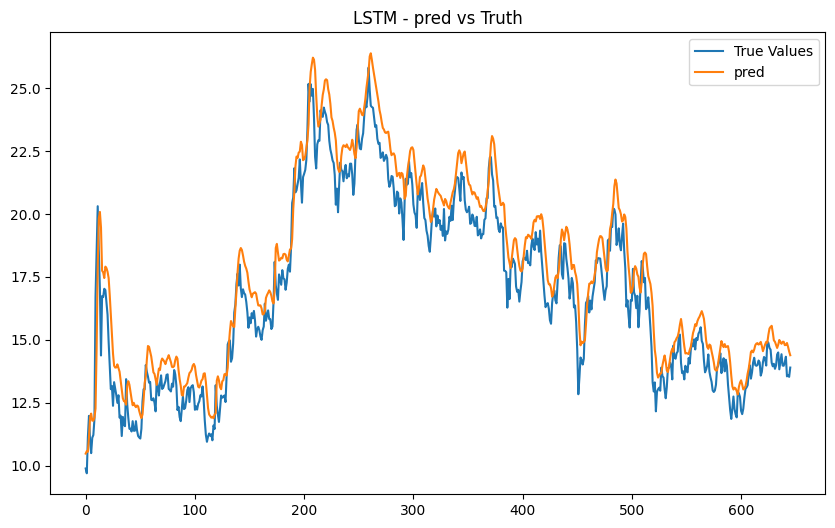

In [8]:
#Implementing the lstm model
lstm_model = lstm(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    lstm_model.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = lstm_model(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = lstm_model(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("LSTM - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

lstm_model.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = lstm_model(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())


pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]


mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nLSTM Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("LSTM - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.38797078  9.96249113]


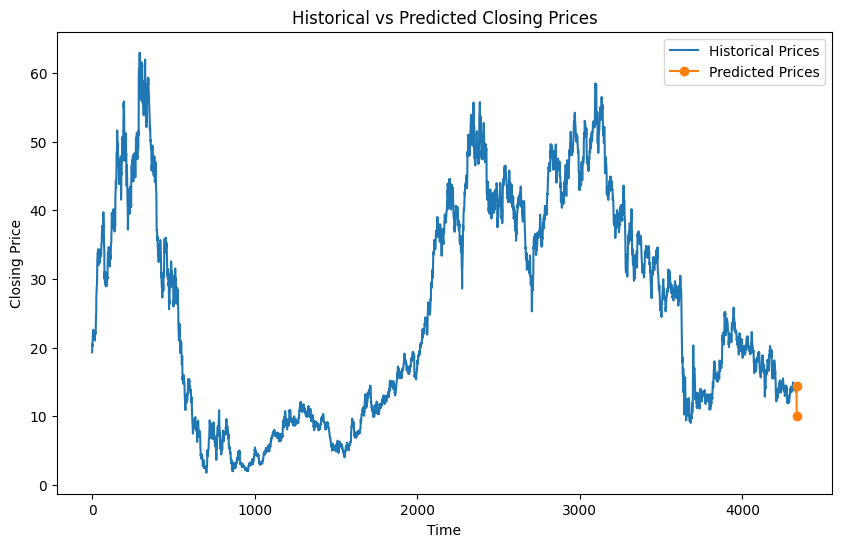

In [9]:
last_sequence = dataset_scaled[-past_days:, :]

predictions = []

lstm_model.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = lstm_model(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0243, Val Loss: 0.0005
Epoch 2/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 3/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 4/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 11/20, training Loss: 0.0002, Val Loss: 0.0004
Epoch 12/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 13/20, training Loss: 0.0002, Val Loss: 0.0004
Epoch 14/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 15/20, training Loss: 0.0002, Val Loss: 0.0005
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0004
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0004
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0003
Ep

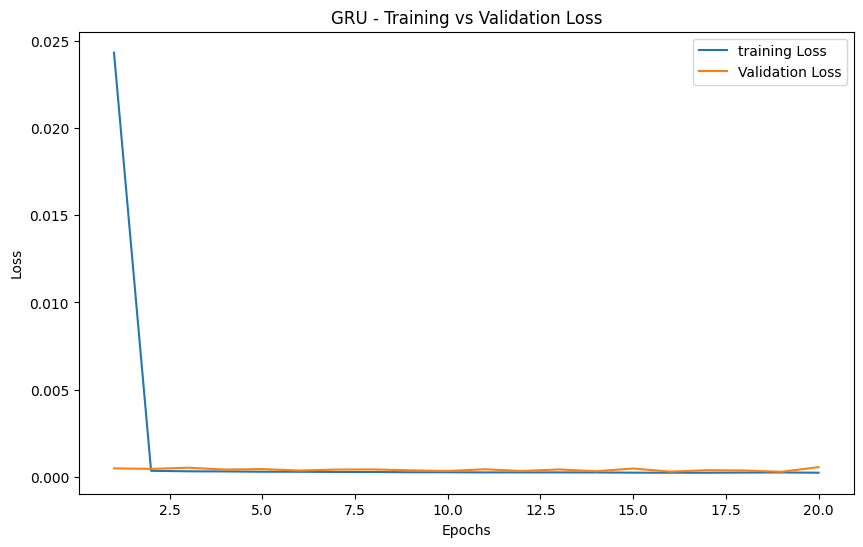


GRU Metrics:
MSE: 1.0351, MAE: 0.8483, RMSE: 1.0174, R2: 0.9214


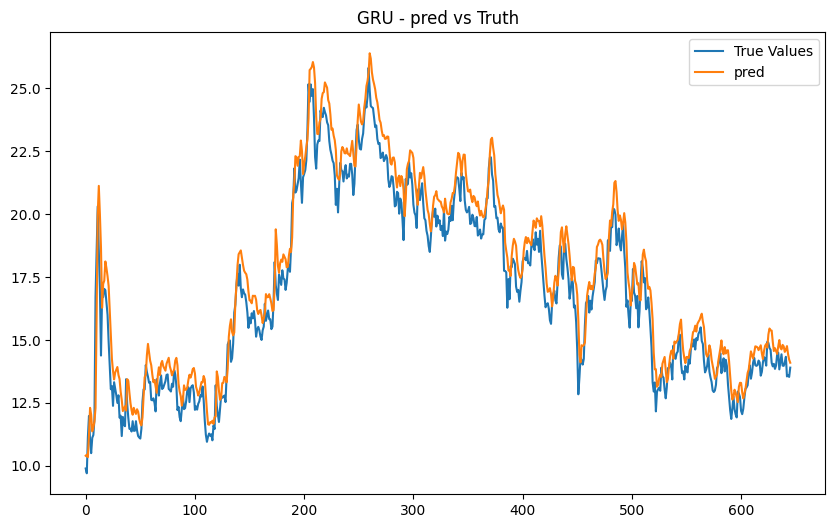

In [10]:
#Implementing the GRU Model
gru_model = gru(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1)
gru_model.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(gru_model.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    gru_model.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = gru_model(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    gru_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = gru_model(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("GRU - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

gru_model.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = gru_model(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)
print(f"\nGRU Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("GRU - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.23875984  7.07865268]


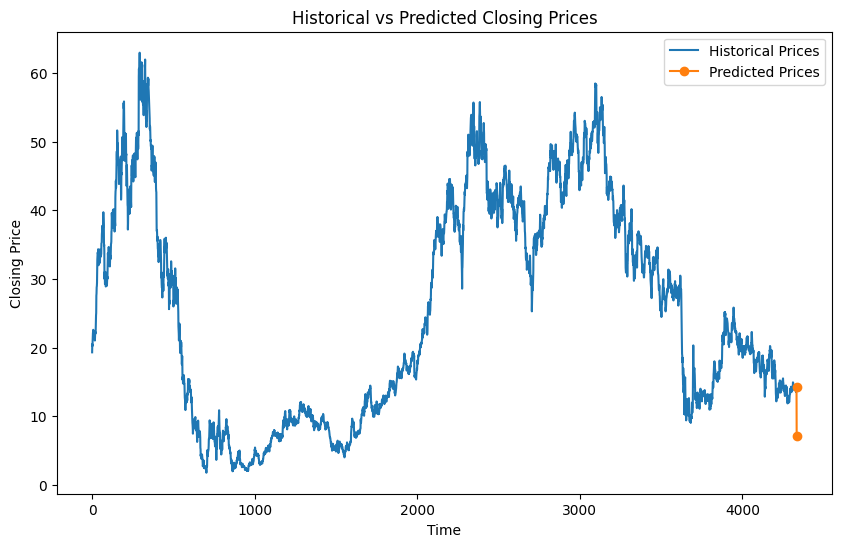

In [11]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

gru_model.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = gru_model(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

# Minimising MAE Loss


Epoch 1/20, training Loss: 0.0674, Val Loss: 0.0150
Epoch 2/20, training Loss: 0.0126, Val Loss: 0.0175
Epoch 3/20, training Loss: 0.0116, Val Loss: 0.0138
Epoch 4/20, training Loss: 0.0116, Val Loss: 0.0160
Epoch 5/20, training Loss: 0.0119, Val Loss: 0.0141
Epoch 6/20, training Loss: 0.0114, Val Loss: 0.0135
Epoch 7/20, training Loss: 0.0110, Val Loss: 0.0184
Epoch 8/20, training Loss: 0.0107, Val Loss: 0.0128
Epoch 9/20, training Loss: 0.0105, Val Loss: 0.0121
Epoch 10/20, training Loss: 0.0105, Val Loss: 0.0134
Epoch 11/20, training Loss: 0.0111, Val Loss: 0.0133
Epoch 12/20, training Loss: 0.0100, Val Loss: 0.0168
Epoch 13/20, training Loss: 0.0104, Val Loss: 0.0147
Epoch 14/20, training Loss: 0.0099, Val Loss: 0.0118
Epoch 15/20, training Loss: 0.0103, Val Loss: 0.0131
Epoch 16/20, training Loss: 0.0097, Val Loss: 0.0119
Epoch 17/20, training Loss: 0.0102, Val Loss: 0.0144
Epoch 18/20, training Loss: 0.0100, Val Loss: 0.0168
Epoch 19/20, training Loss: 0.0097, Val Loss: 0.0117
Ep

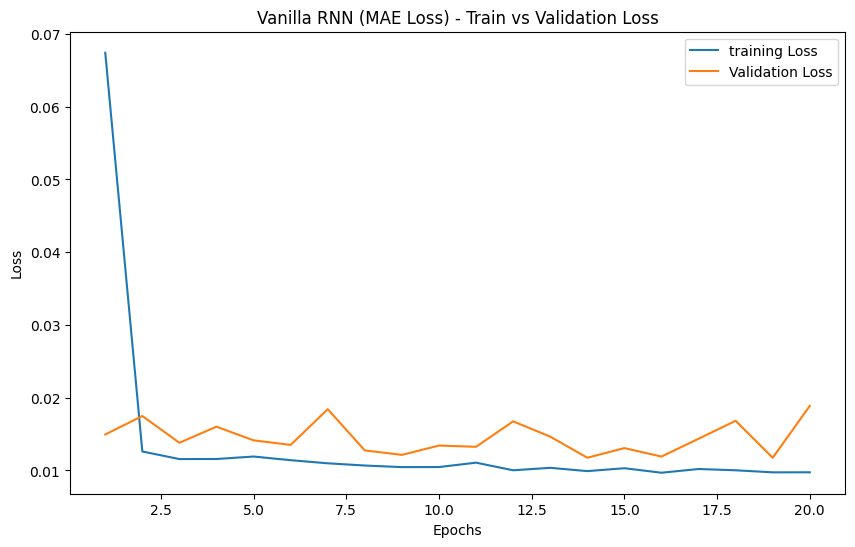


Vanilla RNN Metrics (MAE Loss):
MSE: 0.9821, MAE: 0.8385, RMSE: 0.9910, R2: 0.9254


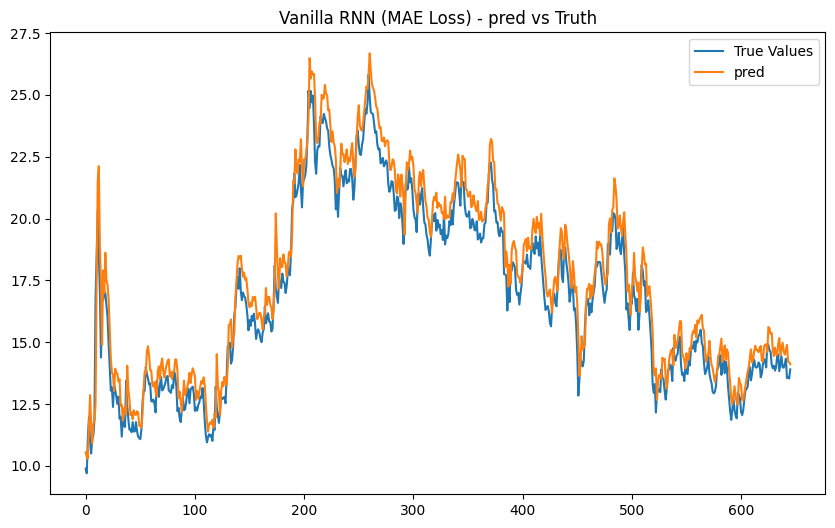

In [12]:
#Implementing the vanilla rnn model
vanilla_rnn = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vanilla_rnn.to(device)

criteria = nn.L1Loss()  #Here, we have specified using the MAE loss fucntion
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)


    vanilla_rnn.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Vanilla RNN (MAE Loss) - Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


vanilla_rnn.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())


pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]


mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nVanilla RNN Metrics (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Vanilla RNN (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.40113993  3.37957086]


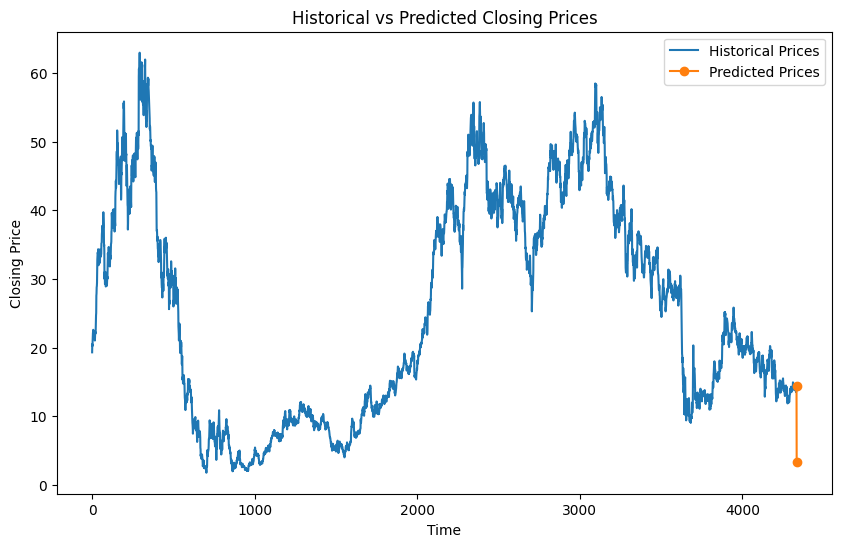

In [13]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]
print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, Training Loss: 0.0726, Val Loss: 0.0196
Epoch 2/20, Training Loss: 0.0163, Val Loss: 0.0206
Epoch 3/20, Training Loss: 0.0161, Val Loss: 0.0172
Epoch 4/20, Training Loss: 0.0145, Val Loss: 0.0179
Epoch 5/20, Training Loss: 0.0135, Val Loss: 0.0168
Epoch 6/20, Training Loss: 0.0132, Val Loss: 0.0160
Epoch 7/20, Training Loss: 0.0134, Val Loss: 0.0154
Epoch 8/20, Training Loss: 0.0130, Val Loss: 0.0143
Epoch 9/20, Training Loss: 0.0122, Val Loss: 0.0151
Epoch 10/20, Training Loss: 0.0119, Val Loss: 0.0211
Epoch 11/20, Training Loss: 0.0121, Val Loss: 0.0160
Epoch 12/20, Training Loss: 0.0113, Val Loss: 0.0224
Epoch 13/20, Training Loss: 0.0120, Val Loss: 0.0130
Epoch 14/20, Training Loss: 0.0109, Val Loss: 0.0184
Epoch 15/20, Training Loss: 0.0110, Val Loss: 0.0158
Epoch 16/20, Training Loss: 0.0108, Val Loss: 0.0129
Epoch 17/20, Training Loss: 0.0107, Val Loss: 0.0125
Epoch 18/20, Training Loss: 0.0105, Val Loss: 0.0150
Epoch 19/20, Training Loss: 0.0100, Val Loss: 0.0183
Ep

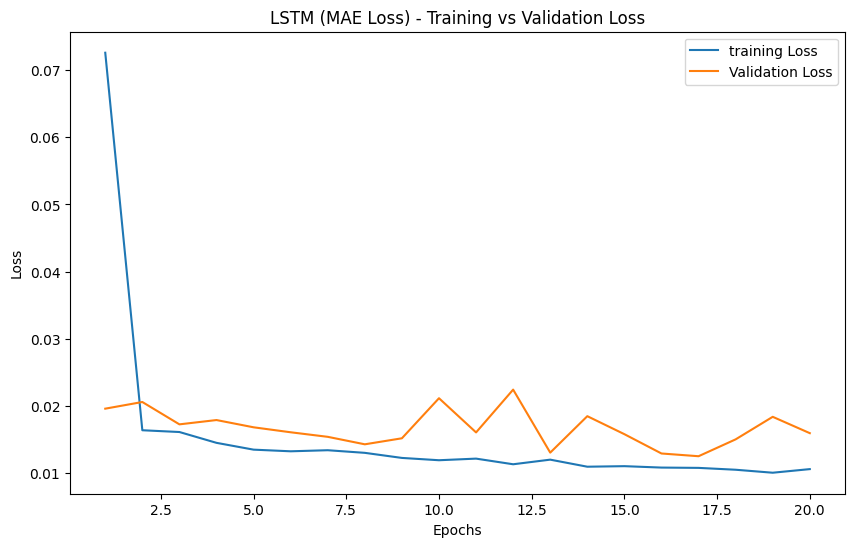


LSTM Metrics (MAE Loss):
MSE: 0.9819, MAE: 0.8086, RMSE: 0.9909, R2: 0.9254


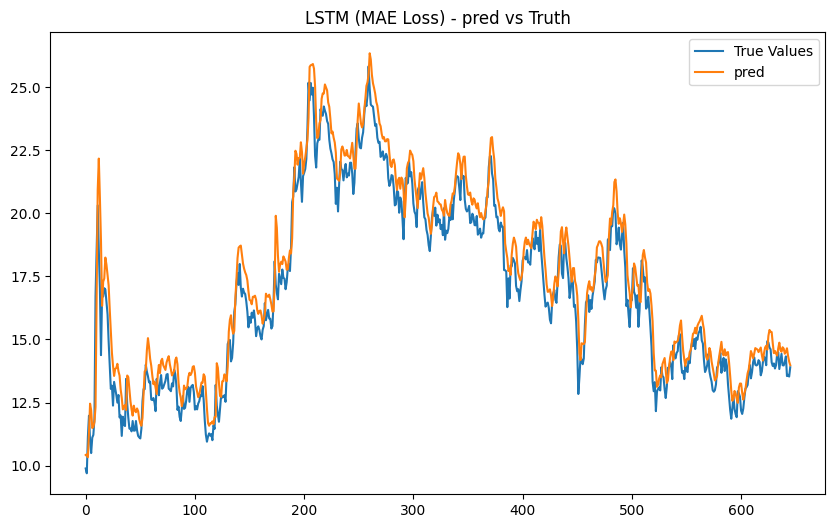

In [14]:
#Implementing lstm model
lstm_model = lstm(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1)
lstm_model.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    lstm_model.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = lstm_model(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = lstm_model(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("LSTM (MAE Loss) - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

lstm_model.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = lstm_model(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nLSTM Metrics (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("LSTM (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.09879184  7.67257775]


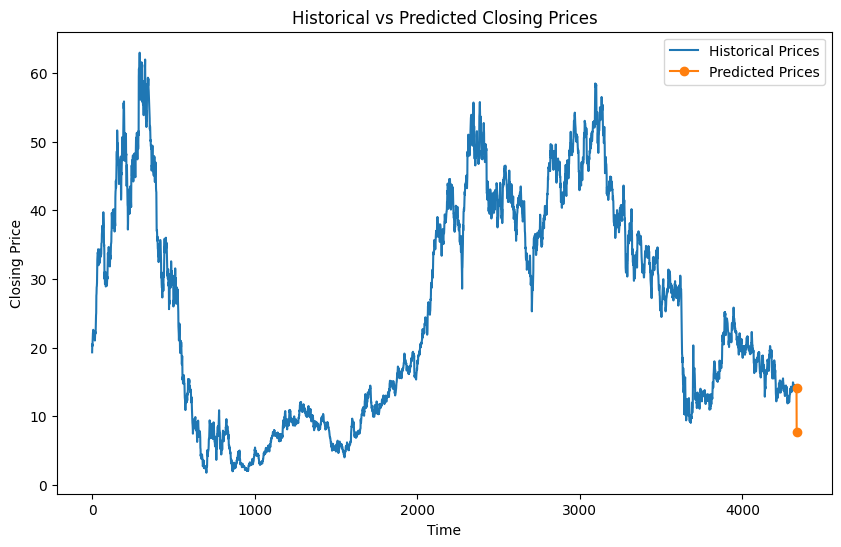

In [15]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

lstm_model.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = lstm_model(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0686, Val Loss: 0.0164
Epoch 2/20, training Loss: 0.0128, Val Loss: 0.0149
Epoch 3/20, training Loss: 0.0117, Val Loss: 0.0144
Epoch 4/20, training Loss: 0.0121, Val Loss: 0.0237
Epoch 5/20, training Loss: 0.0129, Val Loss: 0.0134
Epoch 6/20, training Loss: 0.0109, Val Loss: 0.0132
Epoch 7/20, training Loss: 0.0112, Val Loss: 0.0128
Epoch 8/20, training Loss: 0.0108, Val Loss: 0.0127
Epoch 9/20, training Loss: 0.0105, Val Loss: 0.0128
Epoch 10/20, training Loss: 0.0104, Val Loss: 0.0127
Epoch 11/20, training Loss: 0.0100, Val Loss: 0.0219
Epoch 12/20, training Loss: 0.0105, Val Loss: 0.0132
Epoch 13/20, training Loss: 0.0098, Val Loss: 0.0137
Epoch 14/20, training Loss: 0.0101, Val Loss: 0.0122
Epoch 15/20, training Loss: 0.0100, Val Loss: 0.0141
Epoch 16/20, training Loss: 0.0101, Val Loss: 0.0132
Epoch 17/20, training Loss: 0.0099, Val Loss: 0.0122
Epoch 18/20, training Loss: 0.0109, Val Loss: 0.0190
Epoch 19/20, training Loss: 0.0097, Val Loss: 0.0114
Ep

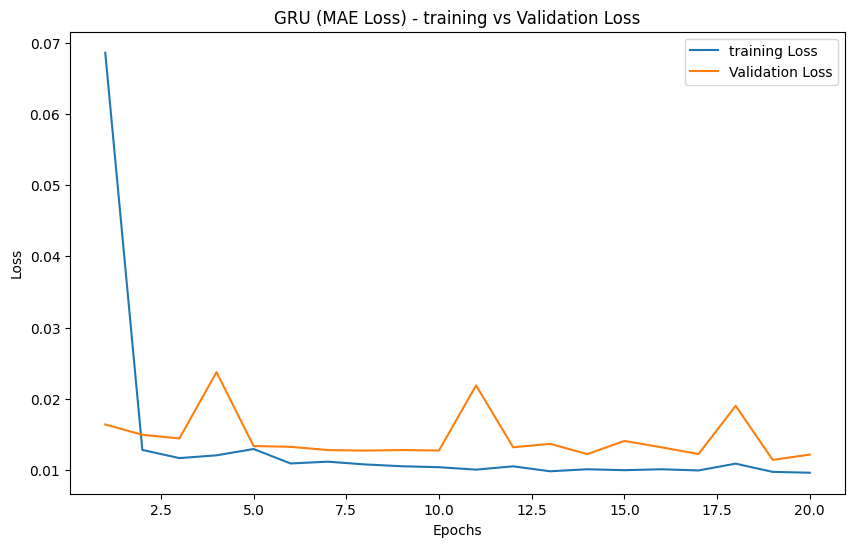


GRU Metrics (MAE Loss):
MSE: 0.5652, MAE: 0.5777, RMSE: 0.7518, R2: 0.9571


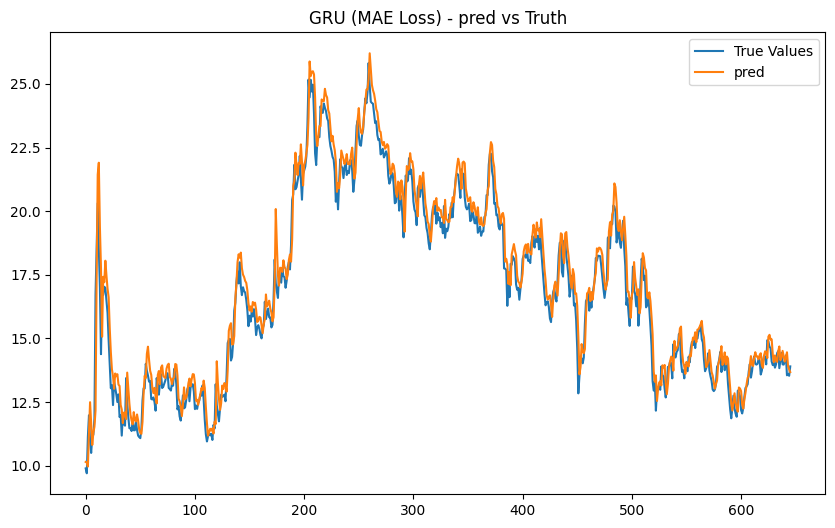

In [16]:
#Implementing gru model
gru_model = gru(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1)
gru_model.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(gru_model.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    gru_model.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = gru_model(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    gru_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = gru_model(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("GRU (MAE Loss) - training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

gru_model.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = gru_model(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nGRU Metrics (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("GRU (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [13.94630753  5.16086213]


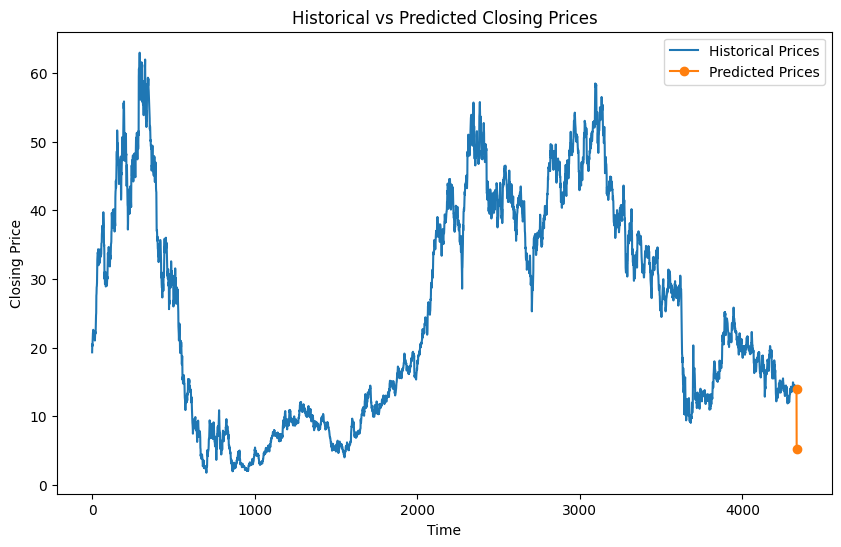

In [17]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

gru_model.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = gru_model(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

# Hyper Parameter Tuning in the Vanilla RNN Model

Epoch 1/20, training Loss: 0.0102, Val Loss: 0.0004
Epoch 2/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 3/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 4/20, training Loss: 0.0003, Val Loss: 0.0006
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0010
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 11/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 12/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 13/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 14/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 15/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0003
Ep

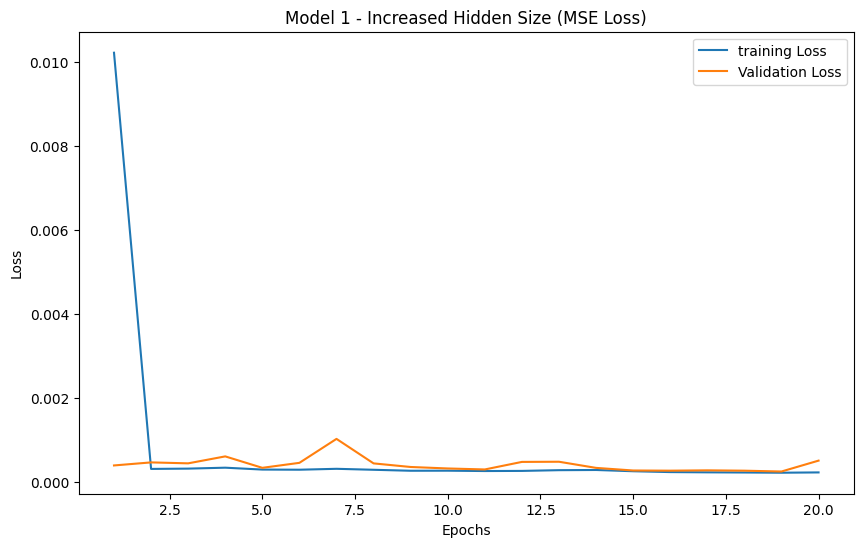


Model 1 - Increased Hidden Size (MSE Loss):
MSE: 0.7197, MAE: 0.6765, RMSE: 0.8484, R²: 0.9453


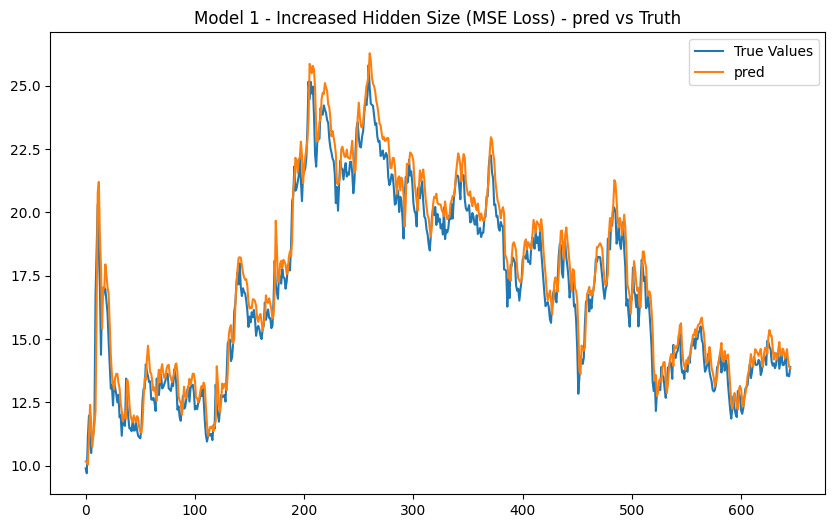

In [18]:
#Here, we have doubled the number of hidden units
vanilla_rnn_model1 = vanilla(input_size=x_training.shape[2], hidden_size=100, output_size=1, num_layers=1, dropout=0.0)
vanilla_rnn_model1.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(vanilla_rnn_model1.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model1.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model1(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model1.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model1(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 1 - Increased Hidden Size (MSE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model1.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model1(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())


pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 1 - Increased Hidden Size (MSE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 1 - Increased Hidden Size (MSE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.05504905  4.8582658 ]


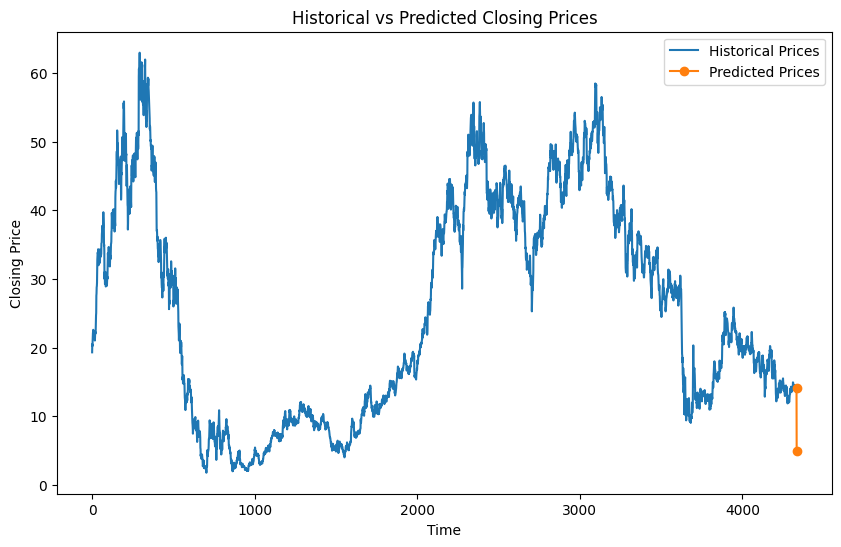

In [19]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model1.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model1(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)


plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0385, Val Loss: 0.0167
Epoch 2/20, training Loss: 0.0127, Val Loss: 0.0161
Epoch 3/20, training Loss: 0.0123, Val Loss: 0.0144
Epoch 4/20, training Loss: 0.0123, Val Loss: 0.0178
Epoch 5/20, training Loss: 0.0114, Val Loss: 0.0192
Epoch 6/20, training Loss: 0.0105, Val Loss: 0.0119
Epoch 7/20, training Loss: 0.0105, Val Loss: 0.0149
Epoch 8/20, training Loss: 0.0111, Val Loss: 0.0116
Epoch 9/20, training Loss: 0.0101, Val Loss: 0.0115
Epoch 10/20, training Loss: 0.0105, Val Loss: 0.0138
Epoch 11/20, training Loss: 0.0101, Val Loss: 0.0114
Epoch 12/20, training Loss: 0.0098, Val Loss: 0.0115
Epoch 13/20, training Loss: 0.0102, Val Loss: 0.0111
Epoch 14/20, training Loss: 0.0106, Val Loss: 0.0172
Epoch 15/20, training Loss: 0.0103, Val Loss: 0.0135
Epoch 16/20, training Loss: 0.0098, Val Loss: 0.0243
Epoch 17/20, training Loss: 0.0107, Val Loss: 0.0114
Epoch 18/20, training Loss: 0.0103, Val Loss: 0.0123
Epoch 19/20, training Loss: 0.0098, Val Loss: 0.0115
Ep

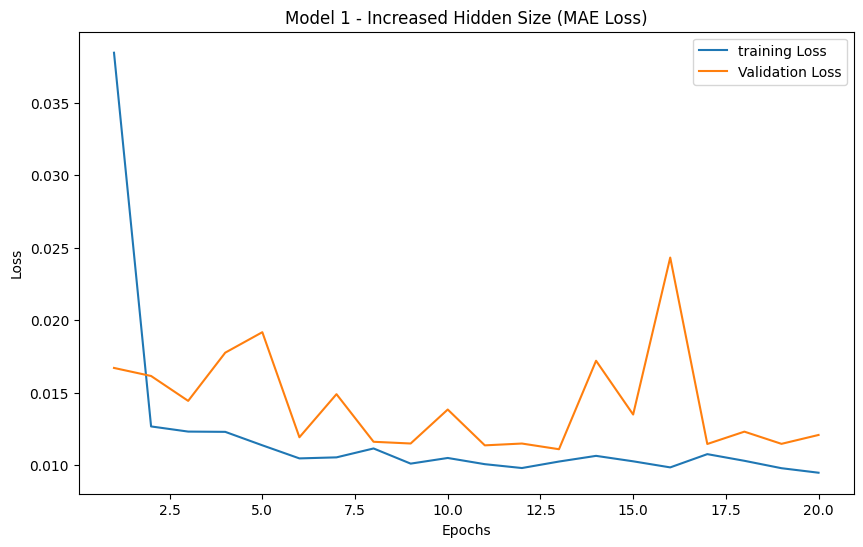


Model 1 - Increased Hidden Size (MAE Loss):
MSE: 0.4747, MAE: 0.5048, RMSE: 0.6890, R²: 0.9639


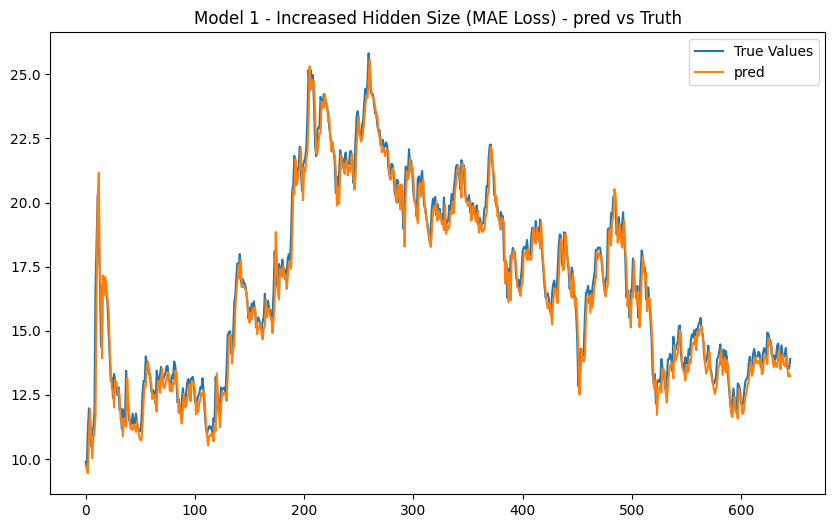

In [20]:
##Here, we have doubled the number of hidden units
vanilla_rnn_model1 = vanilla(input_size=x_training.shape[2], hidden_size=100, output_size=1, num_layers=1, dropout=0.0)
vanilla_rnn_model1.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(vanilla_rnn_model1.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model1.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model1(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model1.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model1(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 1 - Increased Hidden Size (MAE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model1.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model1(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 1 - Increased Hidden Size (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 1 - Increased Hidden Size (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [13.5721532   2.49727949]


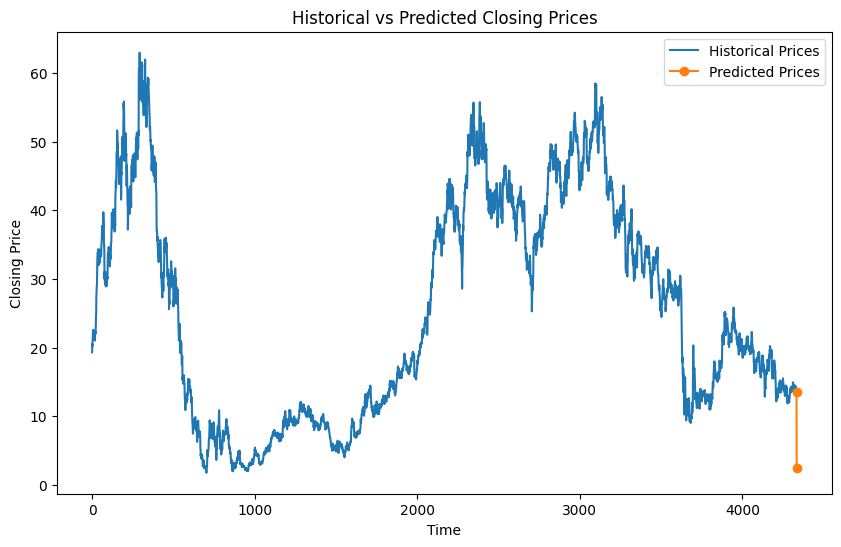

In [21]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model1.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model1(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)


plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0149, Val Loss: 0.0009
Epoch 2/20, training Loss: 0.0005, Val Loss: 0.0006
Epoch 3/20, training Loss: 0.0004, Val Loss: 0.0006
Epoch 4/20, training Loss: 0.0004, Val Loss: 0.0005
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0007
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 11/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 12/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 13/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 14/20, training Loss: 0.0003, Val Loss: 0.0008
Epoch 15/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0005
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0003
Ep

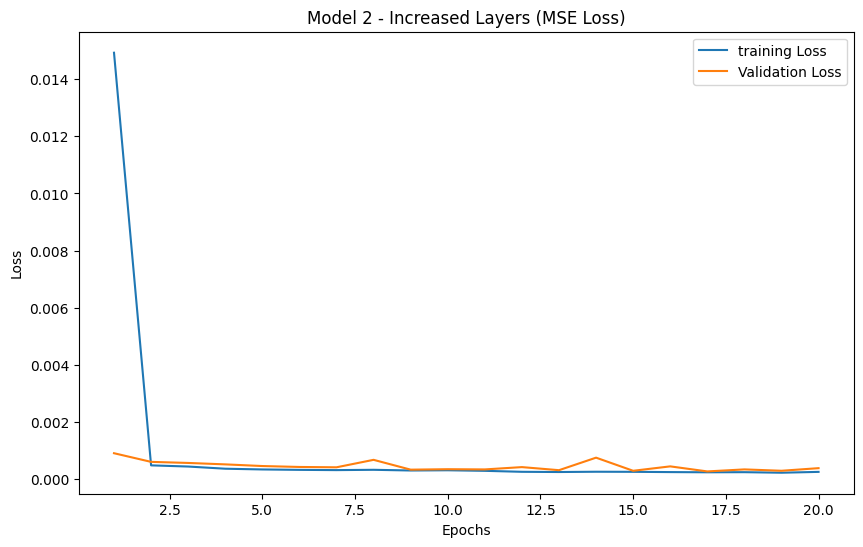


Model 2 - Increased Layers (MSE Loss):
MSE: 0.8441, MAE: 0.7504, RMSE: 0.9187, R²: 0.9359


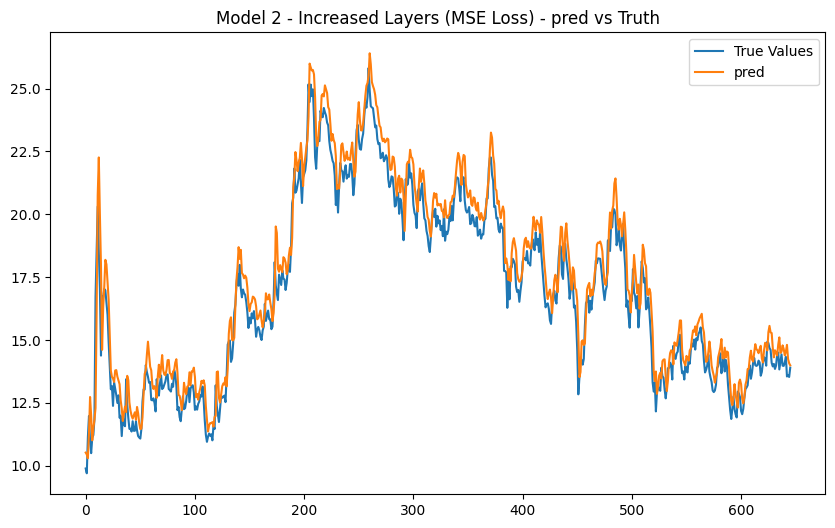

In [22]:
#Here, we have increased the number of hidden layers to 2
vanilla_rnn_model2 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=2, dropout=0.0)
vanilla_rnn_model2.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(vanilla_rnn_model2.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model1.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model2(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model2.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model2(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 2 - Increased Layers (MSE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model2.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model2(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 2 - Increased Layers (MSE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 2 - Increased Layers (MSE Loss) - pred vs Truth")
plt.legend()
plt.show()



Predicted Closing Prices for the Next 2 Days: [14.32438991  4.93171624]


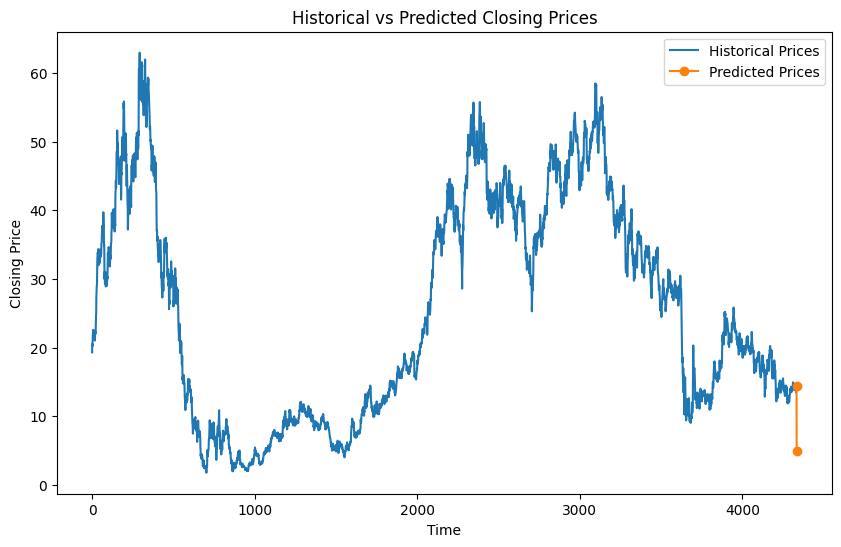

In [23]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model2.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model2(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0470, Val Loss: 0.0236
Epoch 2/20, training Loss: 0.0138, Val Loss: 0.0141
Epoch 3/20, training Loss: 0.0137, Val Loss: 0.0198
Epoch 4/20, training Loss: 0.0133, Val Loss: 0.0161
Epoch 5/20, training Loss: 0.0117, Val Loss: 0.0172
Epoch 6/20, training Loss: 0.0118, Val Loss: 0.0236
Epoch 7/20, training Loss: 0.0123, Val Loss: 0.0119
Epoch 8/20, training Loss: 0.0104, Val Loss: 0.0141
Epoch 9/20, training Loss: 0.0115, Val Loss: 0.0164
Epoch 10/20, training Loss: 0.0108, Val Loss: 0.0124
Epoch 11/20, training Loss: 0.0108, Val Loss: 0.0112
Epoch 12/20, training Loss: 0.0104, Val Loss: 0.0121
Epoch 13/20, training Loss: 0.0118, Val Loss: 0.0123
Epoch 14/20, training Loss: 0.0102, Val Loss: 0.0175
Epoch 15/20, training Loss: 0.0110, Val Loss: 0.0126
Epoch 16/20, training Loss: 0.0117, Val Loss: 0.0164
Epoch 17/20, training Loss: 0.0102, Val Loss: 0.0170
Epoch 18/20, training Loss: 0.0107, Val Loss: 0.0188
Epoch 19/20, training Loss: 0.0116, Val Loss: 0.0116
Ep

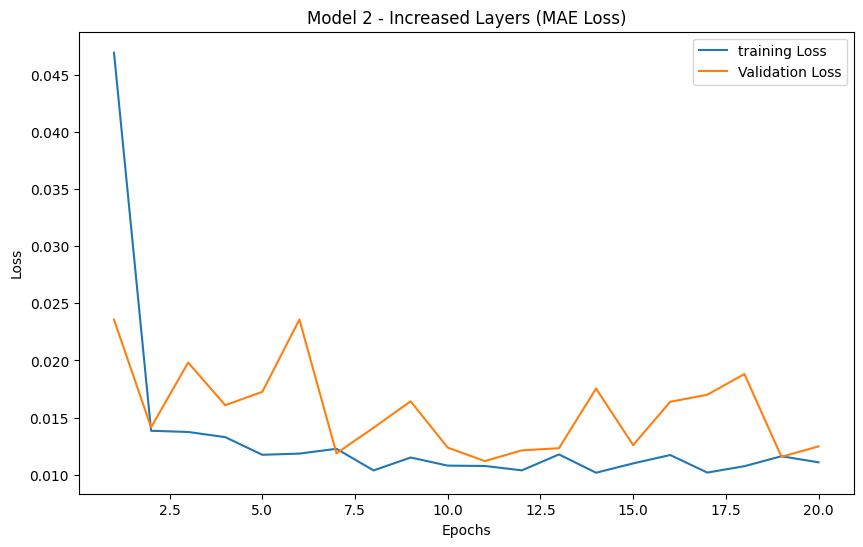


Model 2 - Increased Layers (MAE Loss):
MSE: 0.7161, MAE: 0.6782, RMSE: 0.8462, R²: 0.9456


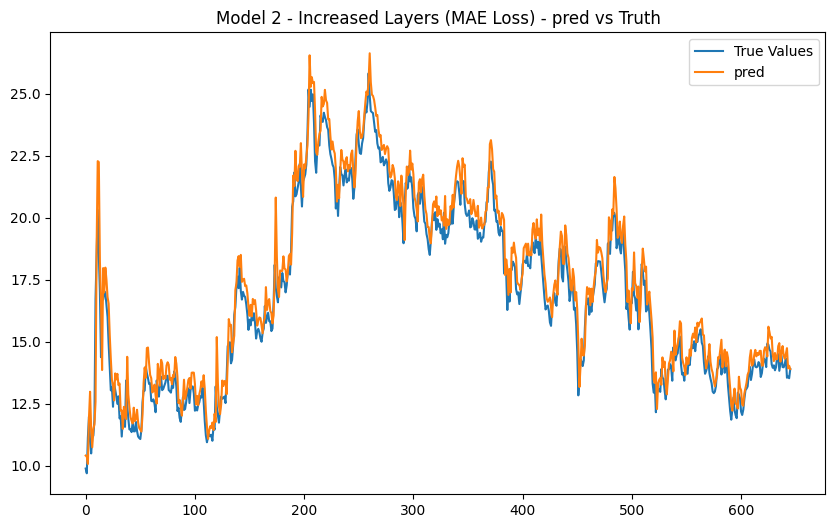

In [24]:
#Here, we have increased the number of layers to 2
vanilla_rnn_model2 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=2, dropout=0.0)
vanilla_rnn_model2.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(vanilla_rnn_model2.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model2.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model2(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model2.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model2(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 2 - Increased Layers (MAE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model2.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model2(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 2 - Increased Layers (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 2 - Increased Layers (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.2283735   2.62570818]


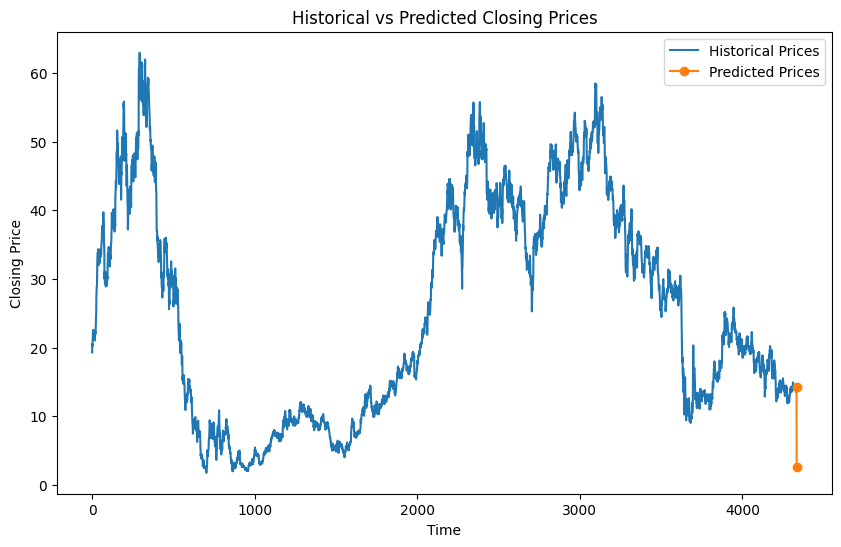

In [25]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model2.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model2(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)


plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20, training Loss: 0.0195, Val Loss: 0.0008
Epoch 2/20, training Loss: 0.0004, Val Loss: 0.0005
Epoch 3/20, training Loss: 0.0004, Val Loss: 0.0007
Epoch 4/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0007
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0005
Epoch 11/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 12/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 13/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 14/20, training Loss: 0.0003, Val Loss: 0.0006
Epoch 15/20, training Loss: 0.0003, Val Loss: 0.0008
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0004
Ep

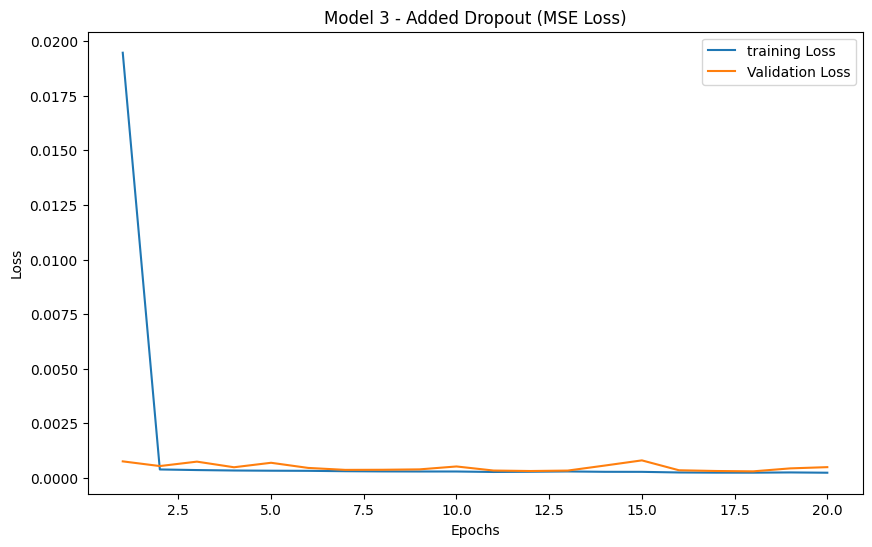


Model 3 - Added Dropout (MSE Loss):
MSE: 0.9316, MAE: 0.7818, RMSE: 0.9652, R²: 0.9292


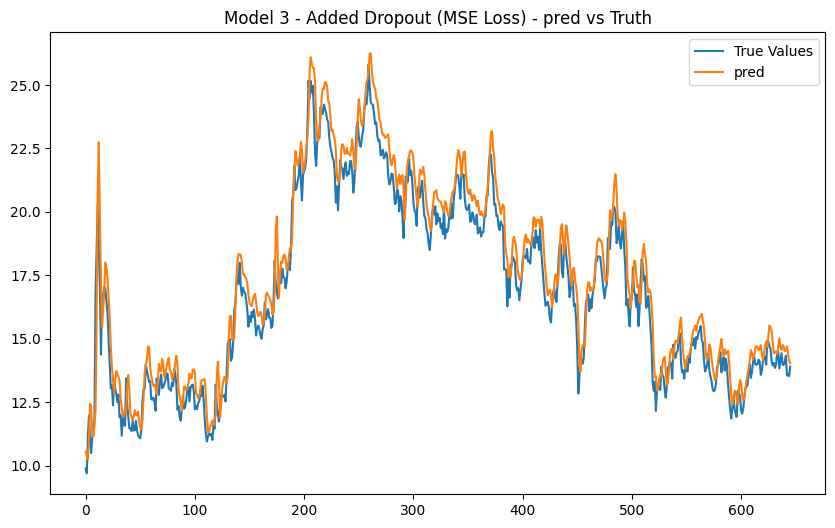

In [26]:
#Here, we have used dropout
vanilla_rnn_model3 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0.3)
vanilla_rnn_model3.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(vanilla_rnn_model3.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model3.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model3(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model3.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model3(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 3 - Added Dropout (MSE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model3.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model3(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 3 - Added Dropout (MSE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 3 - Added Dropout (MSE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.15122319  7.00630756]


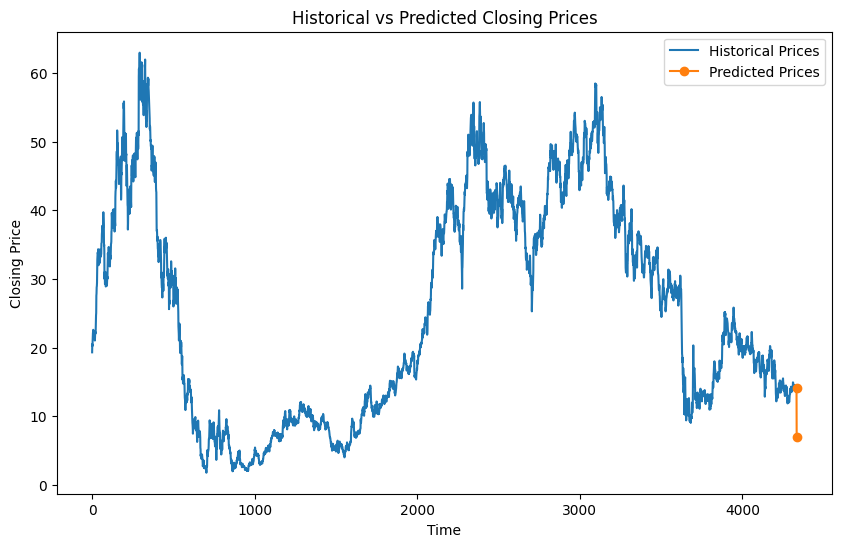

In [27]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model3.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model3(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20, training Loss: 0.0665, Val Loss: 0.0216
Epoch 2/20, training Loss: 0.0128, Val Loss: 0.0238
Epoch 3/20, training Loss: 0.0135, Val Loss: 0.0165
Epoch 4/20, training Loss: 0.0120, Val Loss: 0.0163
Epoch 5/20, training Loss: 0.0116, Val Loss: 0.0134
Epoch 6/20, training Loss: 0.0112, Val Loss: 0.0131
Epoch 7/20, training Loss: 0.0118, Val Loss: 0.0136
Epoch 8/20, training Loss: 0.0115, Val Loss: 0.0200
Epoch 9/20, training Loss: 0.0109, Val Loss: 0.0126
Epoch 10/20, training Loss: 0.0100, Val Loss: 0.0171
Epoch 11/20, training Loss: 0.0100, Val Loss: 0.0125
Epoch 12/20, training Loss: 0.0102, Val Loss: 0.0185
Epoch 13/20, training Loss: 0.0102, Val Loss: 0.0116
Epoch 14/20, training Loss: 0.0098, Val Loss: 0.0114
Epoch 15/20, training Loss: 0.0094, Val Loss: 0.0171
Epoch 16/20, training Loss: 0.0103, Val Loss: 0.0133
Epoch 17/20, training Loss: 0.0099, Val Loss: 0.0119
Epoch 18/20, training Loss: 0.0100, Val Loss: 0.0132
Epoch 19/20, training Loss: 0.0100, Val Loss: 0.0115
Ep

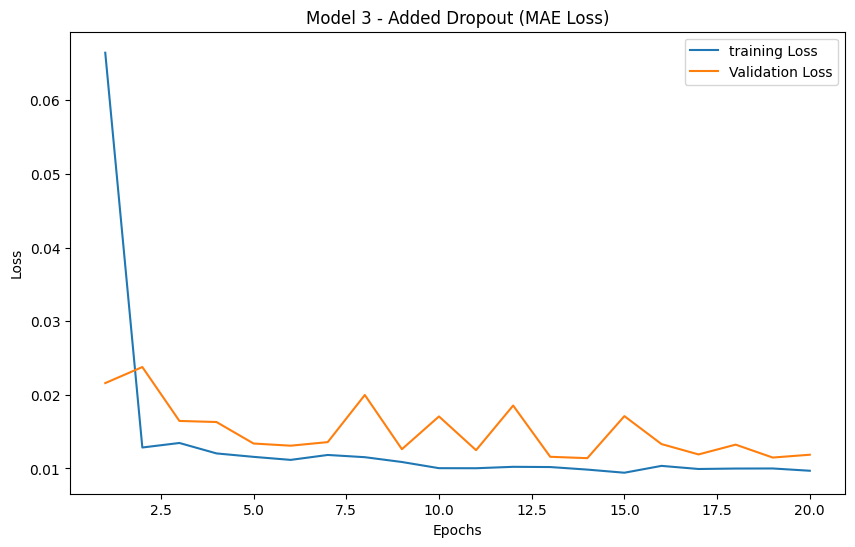


Model 3 - Added Dropout (MAE Loss):
MSE: 0.5992, MAE: 0.6105, RMSE: 0.7741, R²: 0.9545


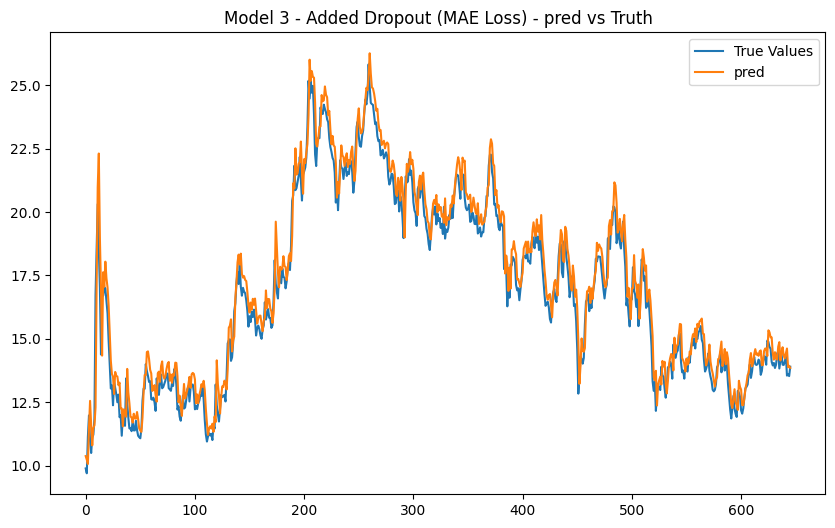

In [28]:
#Here, we have used dropout
vanilla_rnn_model3 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0.3)
vanilla_rnn_model3.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(vanilla_rnn_model3.parameters(), lr=0.001)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model3.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model3(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model3.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model3(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 3 - Added Dropout (MAE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model3.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model3(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 3 - Added Dropout (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 3 - Added Dropout (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.15375527  3.34600605]


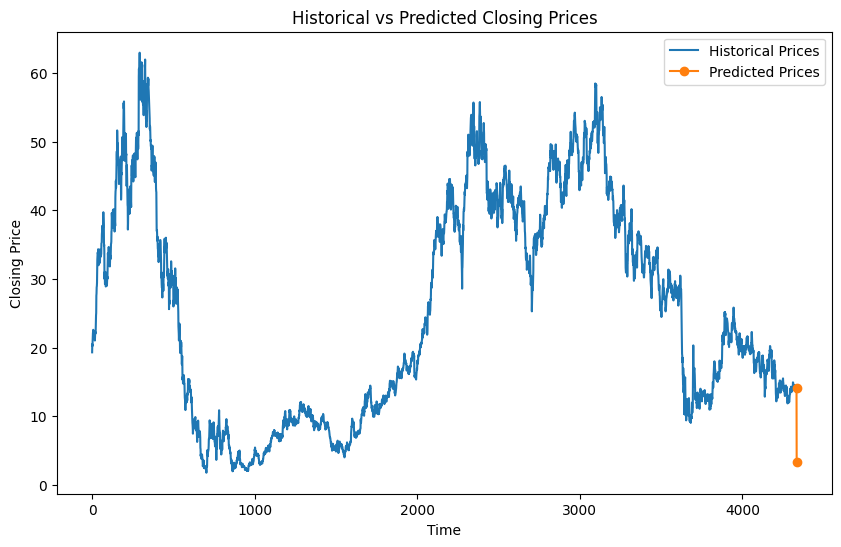

In [29]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model3.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model3(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0124, Val Loss: 0.0004
Epoch 2/20, training Loss: 0.0003, Val Loss: 0.0007
Epoch 3/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 4/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 5/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 6/20, training Loss: 0.0003, Val Loss: 0.0006
Epoch 7/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 8/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 9/20, training Loss: 0.0003, Val Loss: 0.0004
Epoch 10/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 11/20, training Loss: 0.0003, Val Loss: 0.0003
Epoch 12/20, training Loss: 0.0002, Val Loss: 0.0008
Epoch 13/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 14/20, training Loss: 0.0002, Val Loss: 0.0008
Epoch 15/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 16/20, training Loss: 0.0002, Val Loss: 0.0004
Epoch 17/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 18/20, training Loss: 0.0002, Val Loss: 0.0003
Epoch 19/20, training Loss: 0.0002, Val Loss: 0.0003
Ep

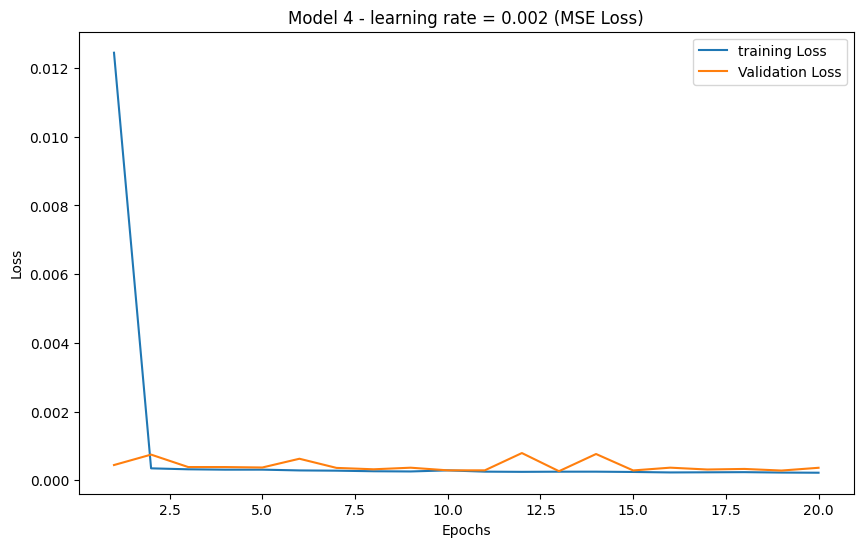


Model 4 - learning rate = 0.002 (MSE Loss):
MSE: 0.6736, MAE: 0.6569, RMSE: 0.8207, R²: 0.9488


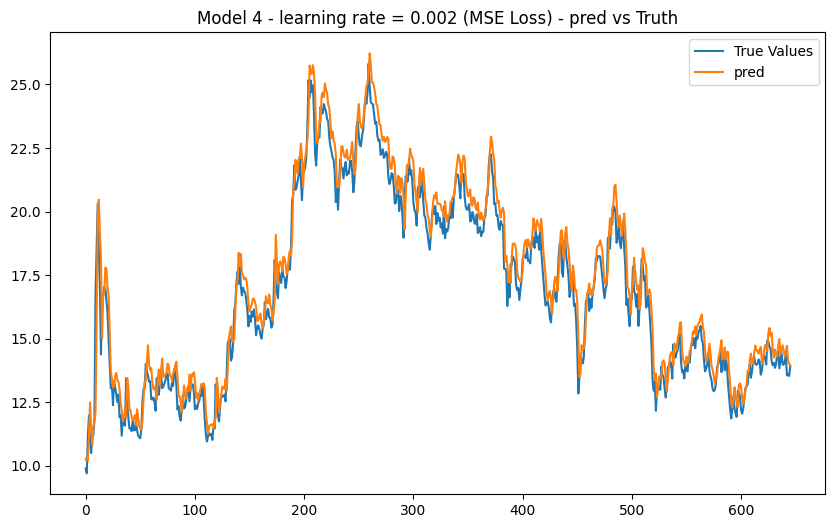

In [30]:
#Here, we have doubled the learning rate
vanilla_rnn_model4 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0.0)
vanilla_rnn_model4.to(device)

criteria = nn.MSELoss()
optim = torch.optim.Adam(vanilla_rnn_model4.parameters(), lr=0.002)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model4.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model4(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model4.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model4(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 4 - learning rate = 0.002 (MSE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model4.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model4(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)
print(f"\nModel 4 - learning rate = 0.002 (MSE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 4 - learning rate = 0.002 (MSE Loss) - pred vs Truth")
plt.legend()
plt.show()


Predicted Closing Prices for the Next 2 Days: [14.23187391  4.35175633]


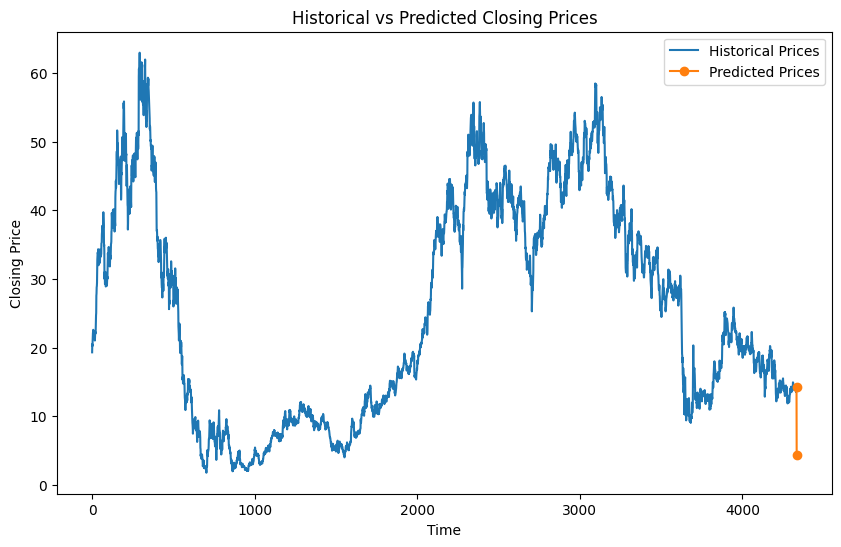

In [31]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model4.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model4(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Epoch 1/20, training Loss: 0.0333, Val Loss: 0.0199
Epoch 2/20, training Loss: 0.0138, Val Loss: 0.0177
Epoch 3/20, training Loss: 0.0114, Val Loss: 0.0205
Epoch 4/20, training Loss: 0.0112, Val Loss: 0.0140
Epoch 5/20, training Loss: 0.0119, Val Loss: 0.0119
Epoch 6/20, training Loss: 0.0121, Val Loss: 0.0171
Epoch 7/20, training Loss: 0.0100, Val Loss: 0.0119
Epoch 8/20, training Loss: 0.0107, Val Loss: 0.0119
Epoch 9/20, training Loss: 0.0104, Val Loss: 0.0147
Epoch 10/20, training Loss: 0.0099, Val Loss: 0.0159
Epoch 11/20, training Loss: 0.0101, Val Loss: 0.0112
Epoch 12/20, training Loss: 0.0109, Val Loss: 0.0111
Epoch 13/20, training Loss: 0.0107, Val Loss: 0.0114
Epoch 14/20, training Loss: 0.0095, Val Loss: 0.0110
Epoch 15/20, training Loss: 0.0105, Val Loss: 0.0133
Epoch 16/20, training Loss: 0.0106, Val Loss: 0.0177
Epoch 17/20, training Loss: 0.0103, Val Loss: 0.0121
Epoch 18/20, training Loss: 0.0117, Val Loss: 0.0143
Epoch 19/20, training Loss: 0.0096, Val Loss: 0.0220
Ep

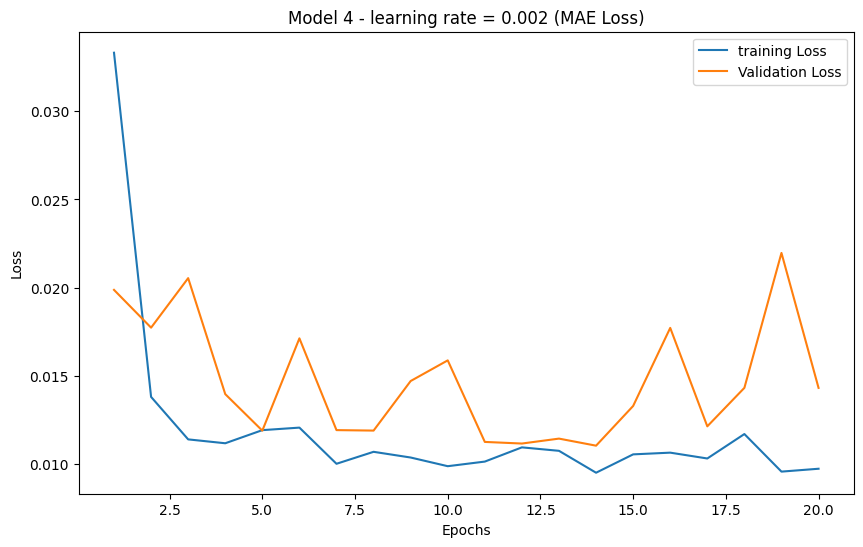


Model 4 - learning rate = 0.002 (MAE Loss):
MSE: 0.6493, MAE: 0.6458, RMSE: 0.8058, R²: 0.9507


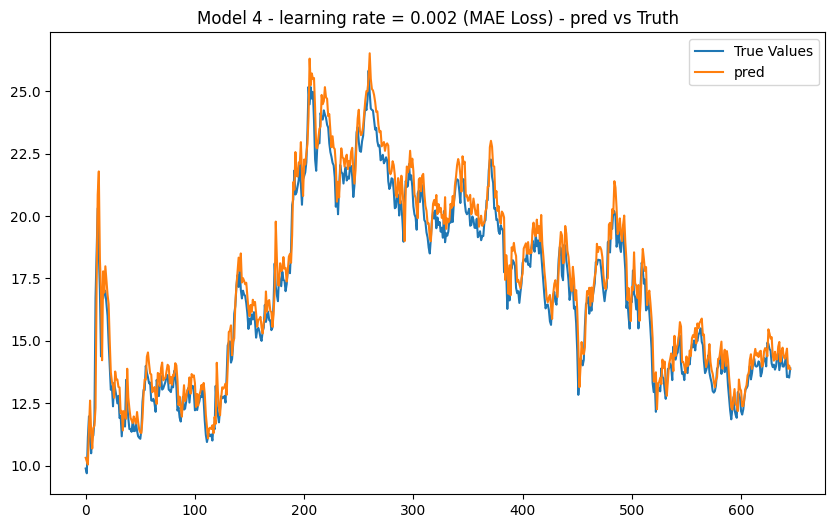

In [32]:
#Here, we have doubled the learning rate
vanilla_rnn_model4 = vanilla(input_size=x_training.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0)
vanilla_rnn_model4.to(device)

criteria = nn.L1Loss()
optim = torch.optim.Adam(vanilla_rnn_model4.parameters(), lr=0.002)
epochs = 20

training_losses, val_losses = [], []
for epoch in range(epochs):
    vanilla_rnn_model4.train()
    training_loss = 0
    for x_batch, y_batch in training_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optim.zero_grad()
        outputs = vanilla_rnn_model4(x_batch)
        loss = criteria(outputs.squeeze(), y_batch)
        loss.backward()
        optim.step()
        training_loss += loss.item()
    training_loss /= len(training_load)
    training_losses.append(training_loss)

    vanilla_rnn_model4.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_load:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = vanilla_rnn_model4(x_batch)
            val_loss += criteria(outputs.squeeze(), y_batch).item()
    val_loss /= len(val_load)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, training Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label="training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Model 4 - learning rate = 0.002 (MAE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

vanilla_rnn_model4.eval()
pred, truth_val = [], []
with torch.no_grad():
    for x_batch, y_batch in test_load:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vanilla_rnn_model4(x_batch)
        pred.extend(outputs.squeeze().cpu().numpy())
        truth_val.extend(y_batch.cpu().numpy())

pred_rescale = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in pred])[:, 4]
truth_val_rescale = scaler.inverse_transform([[0, 0, 0, 0, t, 0] for t in truth_val])[:, 4]

mse = mean_squared_error(truth_val_rescale, pred_rescale)
mae = mean_absolute_error(truth_val_rescale, pred_rescale)
rmse = np.sqrt(mse)
r2 = r2_score(truth_val_rescale, pred_rescale)

print(f"\nModel 4 - learning rate = 0.002 (MAE Loss):\nMSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(truth_val_rescale, label="True Values")
plt.plot(pred_rescale, label="pred")
plt.title("Model 4 - learning rate = 0.002 (MAE Loss) - pred vs Truth")
plt.legend()
plt.show()

Predicted Closing Prices for the Next 2 Days: [14.2624749   1.44911005]


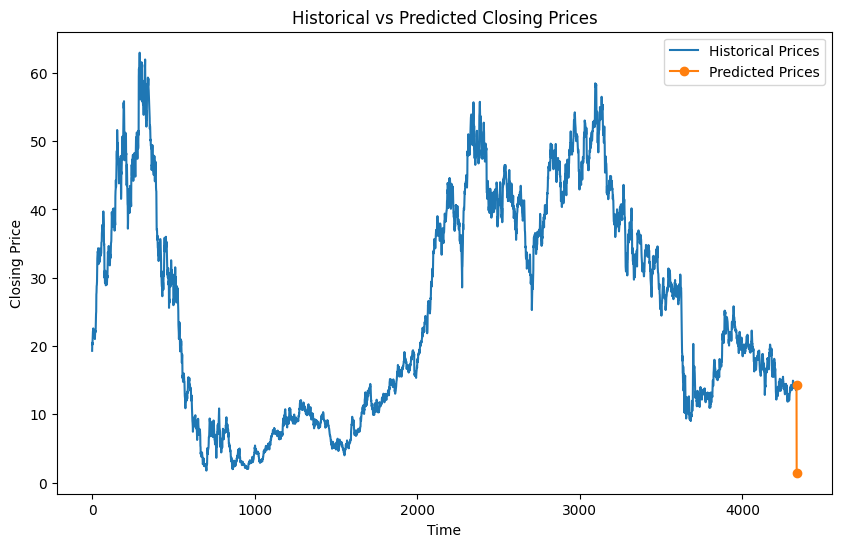

In [33]:

last_sequence = dataset_scaled[-past_days:, :]

predictions = []

vanilla_rnn_model4.eval()
with torch.no_grad():
    for _ in range(2):

        input_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        next_pred_scaled = vanilla_rnn_model4(input_sequence).squeeze().cpu().numpy()

        predictions.append(next_pred_scaled)

        next_row = np.zeros(last_sequence.shape[1])
        next_row[target_index] = next_pred_scaled
        last_sequence = np.vstack([last_sequence[1:], next_row])

predictions_rescaled = scaler.inverse_transform([[0, 0, 0, 0, p, 0] for p in predictions])[:, 4]

print("Predicted Closing Prices for the Next 2 Days:", predictions_rescaled)

plt.figure(figsize=(10, 6))
historical_prices = dataset['Close'].values
plt.plot(range(len(historical_prices)), historical_prices, label="Historical Prices")
plt.plot(range(len(historical_prices), len(historical_prices) + 2), predictions_rescaled, label="Predicted Prices", marker='o')
plt.title("Historical vs Predicted Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()